In [1]:
import sys
sys.path.append('..')
import os
from protein_map_visualisation_tools import generate_embedding_map_from_database
from epitope_mask import get_epitope_mask

parent_dir = os.path.abspath('..')                # path to parent directory
data_dir = parent_dir + '/data/spike_proteins/'   # path to datasets


## 2D Protein Maps (no mask)

In [ ]:
# Generates different maps using all combinations of encoding types and dimensionality reduction techniques

for method in ['PCA', 'tSNE', 'UMAP']:
     for encoding_type in ['One_hot', 'One_hot_6_bit', 'Binary_5_bit', 'Hydrophobicity_matrix',
                       'Meiler_parameters', 'Acthely_factors', 'PAM250', 'BLOSUM62', 'Miyazawa_energies',
                       'Micheletti_potentials', 'AESNN3', 'ANN4D', 'ProtVec']:
         if method == 'UMAP' and encoding_type == 'PAM250':
             for metric in ['cosine', 'euclidean']:
                 for seed in [1, 42]:
                     generate_embedding_map_from_database('1_in_500_cleaned_aligned.afa', encoding_type=encoding_type, method=method, UMAP_metric=metric, seed=seed)
         else:
             generate_embedding_map_from_database('1_in_500_cleaned_aligned.afa', encoding_type=encoding_type, method=method)

## 2D Protein Maps (with epitope mask)


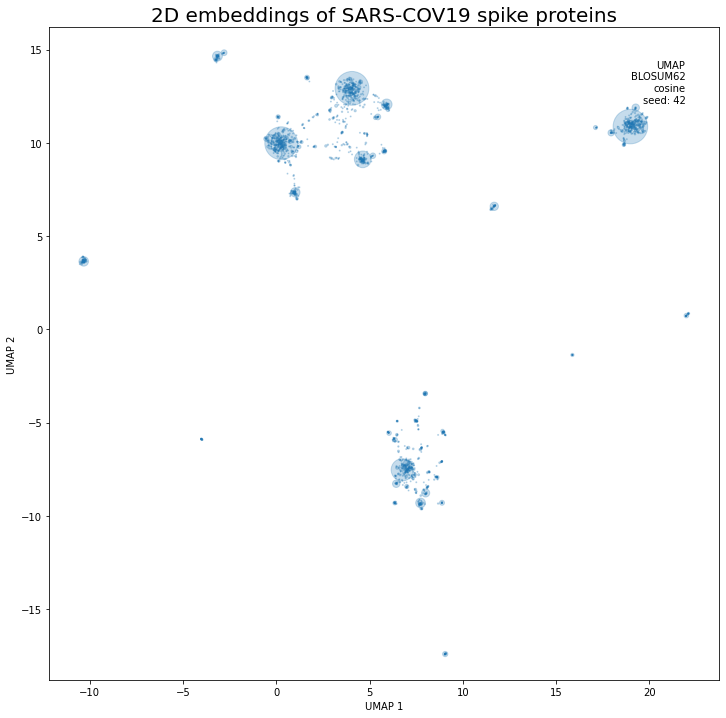

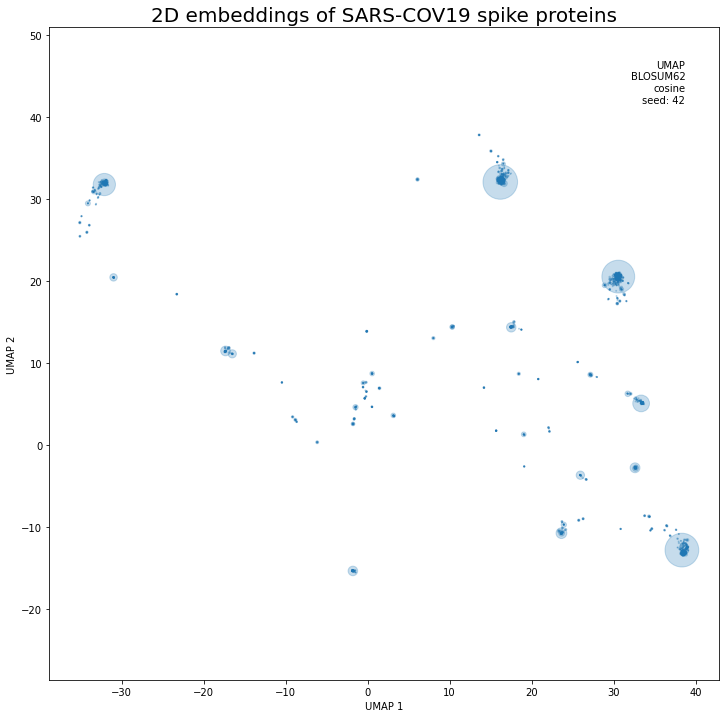

In [3]:
# generate the epitope mask
mask, reference_seq = get_epitope_mask(fasta_file='reference_spike.fasta',
                        dssp_file='reference_spike.dssp',
                        data_directory='../data/spike_protein_pdb/',
                        aligned_file='../data/spike_protein_sequences/1_in_500_cleaned_aligned.afa')

# without mask
generate_embedding_map_from_database('1_in_500_cleaned_aligned.afa',encoding_type='BLOSUM62',method='UMAP')
# with mask
generate_embedding_map_from_database('1_in_500_cleaned_aligned.afa',encoding_type='BLOSUM62',method='UMAP',mask=mask)

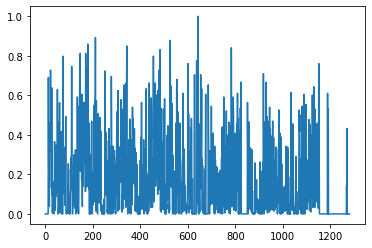

In [5]:
import matplotlib.pyplot as plt
plt.plot(mask)